# Plot the Scatter Plot and Time Series Errors

In [8]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/tommy/ml_drought


In [9]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [10]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [11]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

In [12]:
import sys
sys.path.append("../neuralhydrology")

from neuralhydrology.evaluation.metrics import nse, mse, rmse, kge, fdc_fms, fdc_fhv, fdc_flv, calculate_all_metrics, calculate_metrics

# Read in the CAMELS data

In [13]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read AWS Trained Models

In [40]:
# ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
ealstm_preds = xr.open_dataset(data_dir / "RUNOFF/ealstm_epoch30_ensemble2/results.nc")
ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]
ealstm_preds = ealstm_preds.rename({"discharge_spec_obs": "obs", "discharge_spec_sim": "sim"})
ealstm_df = ealstm_preds.to_dataframe().reset_index()

In [41]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble
lstm_df = lstm_preds.to_dataframe().reset_index()

In [16]:
metric_df = pd.read_csv(data_dir / "runs/ensemble/metric_df.csv", index_col=0)
metric_df.columns = [c.lower() for c in metric_df.columns]
metric_df.head()

,station_id,nse,kge,mse,fhv,fms,flv
0,10002,0.898328,0.857653,0.229347,-10.042169,20.175607,4.281218
1,10003,0.926555,0.881110,0.111980,-6.074578,1.342742,28.237229
2,1001,0.876090,0.920412,0.509755,3.647934,-23.746845,70.234474
3,101002,0.757246,0.647206,0.300506,-25.176707,-4.734227,73.409471
4,101005,0.824926,0.796430,0.208704,-18.346511,1.971726,45.197245


# FUSE Data

In [17]:
all_paths = [d for d in (data_dir / "RUNOFF/FUSE/Timeseries_SimQ_Best/").glob("*_Best_Qsim.txt")]

if not (data_dir / "RUNOFF/ALL_fuse_ds.nc").exists():
    all_dfs = []
    for txt in tqdm(all_paths):
        df = pd.read_csv(txt, skiprows=3, header=0)
        df.columns = [c.rstrip().lstrip() for c in df.columns]
        df = df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})
        df["time"] = pd.to_datetime(df[["year", "month", "day"]])
        station_id = int(str(txt).split("/")[-1].split("_")[0])
        df["station_id"] = [station_id for _ in range(len(df))]
        df = df.drop(["year", "month", "day", "HH"], axis=1).set_index(["station_id", "time"])
        all_dfs.append(df)
        
    fuse_ds = pd.concat(all_dfs).to_xarray()
    fuse_ds.to_netcdf(data_dir / "RUNOFF/ALL_fuse_ds.nc")
    
else:
    fuse_ds = xr.open_dataset(data_dir / "RUNOFF/ALL_fuse_ds.nc")

In [18]:
fuse_ds = fuse_ds.sel(time=slice('1998-01-01', '2009-01-01'))

In [19]:
# join with observations for stations that exist
obs = (
    ds.sel(station_id=np.isin(ds["station_id"], fuse_ds["station_id"]), time=fuse_ds["time"])["discharge_spec"]
).rename("obs")
fuse_data = fuse_ds.sel(station_id=obs.station_id).merge(obs)

In [20]:
fuse_data

<xarray.Dataset>
Dimensions:          (station_id: 519, time: 4018)
Coordinates:
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
  * time             (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
Data variables:
    SimQ_TOPMODEL    (station_id, time) float64 ...
    SimQ_ARNOVIC     (station_id, time) float64 ...
    SimQ_PRMS        (station_id, time) float64 ...
    SimQ_SACRAMENTO  (station_id, time) float64 ...
    obs              (time, station_id) float64 ...

# Match Stations / Times

In [21]:
all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)

In [22]:
# lstm_preds = lstm_preds.sel(station_id=all_stations_lstm, time=fuse_data.time)
# ealstm_preds = ealstm_preds.sel(station_id=all_stations_ealstm, time=fuse_data.time)

# Errors

In [23]:
from scripts.drafts.calculate_error_scores import calculate_ml_errors, error_func

In [43]:
ealstm_metric_df = calculate_ml_errors(ealstm_preds).set_index("station_id")
lstm_metric_df = calculate_ml_errors(lstm_preds).set_index("station_id")

In [44]:
metric_df["rmse"] = np.sqrt(metric_df["mse"])
lstm_metric_df["rmse"] = np.sqrt(lstm_metric_df["mse"])
ealstm_metric_df["rmse"] = np.sqrt(ealstm_metric_df["mse"])
display(metric_df.set_index("station_id").sort_index().head())
display(lstm_metric_df.sort_index().head())

,nse,kge,mse,fhv,fms,flv,rmse
station_id,,,,,,,
1001,0.876090,0.920412,0.509755,3.647934,-23.746845,70.234474,0.713971
2001,0.796159,0.737755,1.295476,-23.338750,-8.885240,8.945649,1.138190
2002,0.799168,0.721571,2.248968,-26.614591,-20.047770,54.950795,1.499656
3003,0.878744,0.851921,4.253649,-13.508330,-20.236829,54.121467,2.062438
4001,0.872644,0.860455,1.789749,-4.687964,-18.653824,39.811433,1.337815


,nse,kge,mse,bias,rmse
station_id,,,,,
1001,0.876090,0.920412,0.509755,4.266320,0.713971
2001,0.796159,0.737755,1.295476,-12.189085,1.138190
2002,0.799168,0.721571,2.248968,-7.375567,1.499656
3003,0.878744,0.851921,4.253648,-0.086631,2.062437
4001,0.872644,0.860455,1.789749,-3.644160,1.337815


# FUSE - Calculate from Sim

In [27]:
from scripts.drafts.calculate_error_scores import FuseErrors

In [174]:
f = FuseErrors(fuse_data)
fuse_errors = f.fuse_errors
fuse_metric_df = fuse_errors

nse: 4it [00:07,  1.93s/it]
kge: 4it [00:08,  2.15s/it]
bias: 4it [00:04,  1.24s/it]
rmse: 4it [00:05,  1.26s/it]


In [29]:
fuse_bias = f.get_metric_df("bias")
fuse_nse_df = f.get_metric_df("nse")
fuse_kge_df = f.get_metric_df("kge")
fuse_kge_df.head()

,PRMS,Sacramento,TOPMODEL,VIC,Name
1001,0.850647,0.856466,0.813894,0.786482,Wick at Tarroul
2001,0.748769,0.742688,0.758969,0.698891,Helmsdale at Kilphedir
2002,0.810254,0.734603,0.756657,0.685371,Brora at Bruachrobie
3003,0.889991,0.887535,0.840244,0.814423,Oykel at Easter Turnaig
4001,0.828668,0.793088,0.733907,0.841072,Conon at Moy Bridge


In [30]:
model = "VIC"
vic_data = f.get_model_df(model)
vic_data.head()

,bias,kge,nse,rmse,Name
1001,12.112858,0.786482,0.766521,0.980059,Wick at Tarroul
2001,-2.899249,0.698891,0.685077,1.414721,Helmsdale at Kilphedir
2002,-2.646902,0.685371,0.681148,1.889598,Brora at Bruachrobie
3003,1.690727,0.814423,0.799981,2.648892,Oykel at Easter Turnaig
4001,-3.086921,0.841072,0.818019,1.599187,Conon at Moy Bridge


# Create Plotting Algos

In [109]:
from typing import Optional, List, Tuple, Dict

def plot_station_scatter(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None,
    color_by_season: bool = None,
):
    # select station
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    if not color_by_season:
        # plot scatter
        ax.plot(d[target_var], d.preds, 'kx', alpha=0.6, label='Data Point')
    else:
        seasons = ds.sel(time=d.index)["time.season"].values
        d["season"] = seasons
        for ix, season in enumerate(d.season.unique()):
            ax.scatter(
                d.loc[d["season"] == season, target_var], 
                d.loc[d["season"] == season, "preds"], 
                color=sns.color_palette()[ix], 
                alpha=0.6, 
                label=season,
                marker="x"
            )
            sns.regplot(
                d.loc[d["season"] == season, target_var], 
                d.loc[d["season"] == season, "preds"], 
                color=sns.color_palette()[ix],
                ax=ax,
                scatter=False,
                ci=None,
            )
    # plot 1:1 line
    max_val = max(ax.get_xlim()[-1], ax.get_ylim()[-1])
    line_1_1_x = np.linspace(0, max_val, 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')
    
    # set the xylim
    ax.set_ylim(0, max_val)
    ax.set_xlim(0, max_val)

    ax.set_xlabel('Observed $[mm d^{-1} km^{-2}]$')
    ax.set_ylabel('Predicted $[mm d^{-1} km^{-2}]$')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    # plot the station
    if plot_years is None:
        data = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
        ax.plot(np.arange(len(data)), data["preds"], label="Sim")
        ax.plot(np.arange(len(data)), data["discharge_spec"], label="Obs", ls=":", color="k")
        #.plot(ax=ax)
    else:
        data = (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id')
        )  # .plot(ax=ax)
        ax.plot(np.arange(len(data)), data["preds"], label="Sim")
        ax.plot(np.arange(len(data)), data["discharge_spec"], label="Obs", ls=":", color="k")

    # get the error metrics
    try:
        rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    except AttributeError:
        rmse_val = np.nan
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    kge_val = metrics_df.query(f"station_id == '{station_id}'").kge.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} NSE: {nse_val:.2f} KGE: {kge_val:.2f}")
    
    return fig, ax


def plot_catchment_time_series(
    df: pd.DataFrame,
    metrics_df: pd.DataFrame,
    catchment_ids: List[str],
    catchment_names: List[str],
    plot_years: List[int] = [2011],
    scale: float = 0.8,
    color_by_season: bool = False,
):
    n_plots = len(catchment_ids)
    station_map = dict(zip(catchment_ids, catchment_names))
    fig, axs = plt.subplots(n_plots, 2, figsize=(12*scale, 6*scale*n_plots))

    for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
    #     fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
        try:
            plot_station(df, station_id, metrics_df, ax=axs[ix, 0], station_name=station_name, plot_years=plot_years)
            axs[ix, 0].legend()
            plot_station_scatter(df, station_id, metrics_df, axs[ix, 1], color_by_season=color_by_season)
        except IndexError:
            # the axes are one dimensional
            plot_station(df, station_id, metrics_df, ax=axs[0], station_name=station_name, plot_years=plot_years)
            plot_station_scatter(df, station_id, metrics_df, axs[1], color_by_season=color_by_season)
        except TypeError:
            print(f"** {station_name} data does not exist in the predictions! **")

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    return fig, axs

# Get the median basins etc.

In [110]:
assert (data_dir / "RUNOFF/all_nse.csv").exists()
assert (data_dir / "RUNOFF/all_bias.csv").exists()

all_nse = pd.read_csv((data_dir / "RUNOFF/all_nse.csv"))
all_bias = pd.read_csv((data_dir / "RUNOFF/all_bias.csv"))

# all_nse

In [111]:
median = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].median()]
min_ = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].min()]
max_ = all_nse.loc[all_nse['LSTM'] == all_nse['LSTM'].max()]

median_station = (median["Station ID"].values, median.Name.values)
min_station = (min_["Station ID"].values, min_.Name.values)
max_station = (max_["Station ID"].values, max_.Name.values)

pd.concat([median, min_, max_])

,Station ID,Name,LSTM,EALSTM,CLASSIC,JULES,PRMS,Sacramento,TOPMODEL,VIC
10,54057,Severn at Haw Bridge,0.936800,0.901804,0.78,0.72,0.880677,0.920232,0.882238,0.877385
3,27034,Ure at Kilgram Bridge,0.882438,0.873945,0.78,0.75,0.846070,0.852412,0.841413,0.844337
5,39001,Thames at Kingston,0.958940,0.901698,0.81,0.82,0.686639,0.882496,0.752798,0.782795


In [112]:
summary_stations = np.vstack([median_station, min_station, max_station]).reshape(3, 2)

# Show basin with the max variance

In [138]:
# find the basin with greatest variance
station_max_variance = all_nse.set_index("Station ID").drop(["Name", "JULES", "CLASSIC"], axis=1).std(axis=1).idxmax()
all_nse.set_index("Station ID").loc[station_max_variance]

Name          Avon at Knapp Mill
LSTM                    0.893129
EALSTM                  0.911995
CLASSIC                      0.6
JULES                      -0.07
PRMS                    0.837635
Sacramento              0.893386
TOPMODEL                0.536147
VIC                     0.907952
Name: 43021, dtype: object

In [148]:
def get_all_data_for_basins(stations: np.ndarray) -> pd.DataFrame:
    df = lstm_preds.sel(station_id=stations).to_dataframe().rename({"sim": "LSTM"}, axis=1)
    e_df = (
        ealstm_preds.sel(station_id=stations).to_dataframe()
        .drop("obs", axis=1).rename({"sim": "EALSTM"}, axis=1)
    )
    f_df = (
        fuse_ds.sel(station_id=stations[np.isin(stations, fuse_ds.station_id)]).to_dataframe()
    )
    data = (df.join(e_df).join(f_df)).reset_index().set_index("station_id")

    return data


In [166]:
stations = np.array([station_max_variance])
df = get_all_data_for_basins(stations=stations).reset_index().set_index(["time"]).drop("station_id", axis=1)

def fixC(colname: str) -> str:
    cname = colname.replace("SimQ_", "")
    cname = "VIC" if cname == "ARNOVIC" else cname
    cname = "Sacramento" if cname == "SACRAMENTO" else cname
    return cname

df.columns = [fixC(c) for c in df.columns]

df.head()

,obs,LSTM,EALSTM,TOPMODEL,VIC,PRMS,Sacramento
time,,,,,,,
1998-01-01,1.59,1.773642,1.725273,1.4756,1.4522,1.5176,1.5968
1998-01-02,1.98,2.597594,2.602101,1.8085,1.6703,1.6894,1.7735
1998-01-03,2.25,3.039324,2.825876,2.2176,1.9110,1.9032,2.0023
1998-01-04,2.42,3.343164,3.161276,2.6319,2.1500,2.1282,2.2573
1998-01-05,2.67,3.763503,3.328459,3.0364,2.3855,2.3548,2.5284


In [186]:
# lstm_metric_df
# ealstm_metric_df

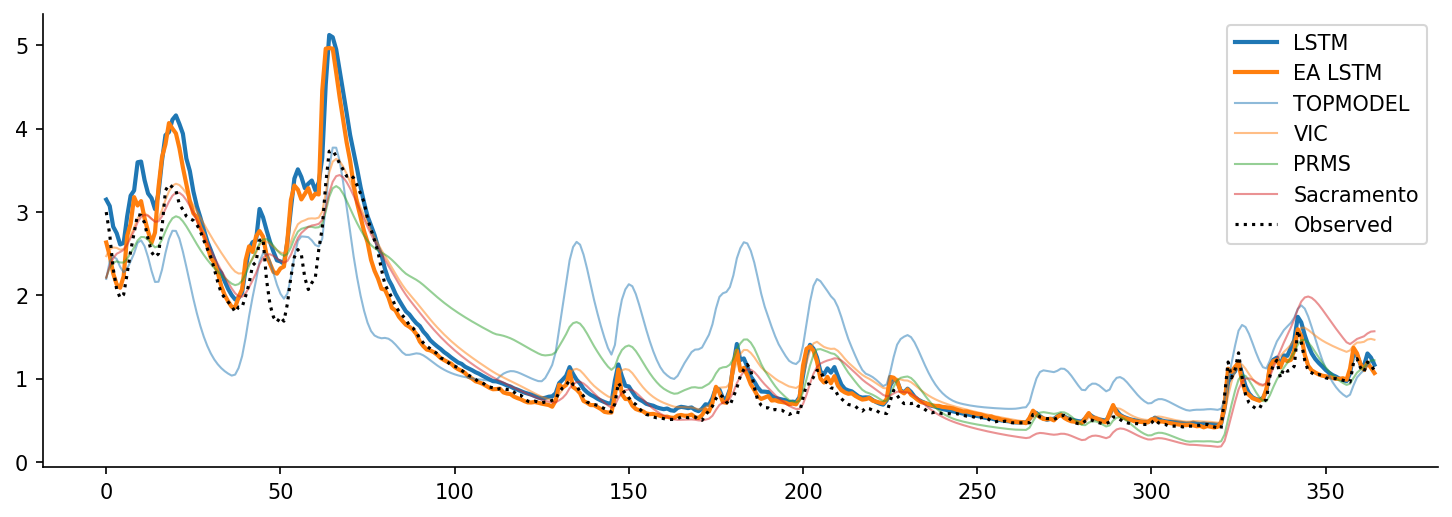

In [171]:
f, ax = plt.subplots(figsize=(12, 4))

data = df.loc["2007"]

ax.plot(np.arange(len(data)), data["LSTM"], color=sns.color_palette()[0], label="LSTM", alpha=1, linewidth=2)
ax.plot(np.arange(len(data)), data["EALSTM"], color=sns.color_palette()[1], label="EA LSTM", alpha=1, linewidth=2)
if plot_conceptual:
    ax.plot(np.arange(len(data)), data["TOPMODEL"], label="TOPMODEL", alpha=0.5, linewidth=1)
    ax.plot(np.arange(len(data)), data["VIC"], label="VIC", alpha=0.5, linewidth=1)
    ax.plot(np.arange(len(data)), data["PRMS"], label="PRMS", alpha=0.5, linewidth=1)
    ax.plot(np.arange(len(data)), data["Sacramento"], label="Sacramento", alpha=0.5, linewidth=1)

ax.plot(np.arange(len(data)), data["obs"], color="k", ls=":", label="Observed")
ax.legend()

ax.set_title(f"{}\nNSE: {} -- Bias: {} -- {}")

sns.despine()

# Show most Arid Basin

In [205]:
static_df = static.to_dataframe()
arid_sid = static_df.loc[static_df["aridity"].idxmax()].name
arid_sid

37033

In [207]:
from scripts.drafts.calculate_error_scores import DeltaError

# calculate all error metrics
processor = DeltaError(ealstm_preds, lstm_preds, fuse_data)
all_preds = processor.all_preds

In [211]:
arid_df = all_preds.sel(station_id=arid_sid).to_dataframe()
arid_df.head()

,station_id,TOPMODEL,ARNOVIC,PRMS,SACRAMENTO,EALSTM,obs,LSTM
time,,,,,,,,
1998-01-01,37033,0.76044,1.2055,1.1129,1.5673,0.908733,0.68,1.003203
1998-01-02,37033,1.18120,1.6905,1.5292,2.2211,1.626952,1.34,1.761296
1998-01-03,37033,0.92908,1.2578,1.1078,1.7091,1.183259,1.88,1.319566
1998-01-04,37033,1.26670,1.8242,1.6569,2.3333,1.429227,1.30,1.868156
1998-01-05,37033,1.12270,1.5473,1.3741,2.0364,1.520344,2.81,1.816567


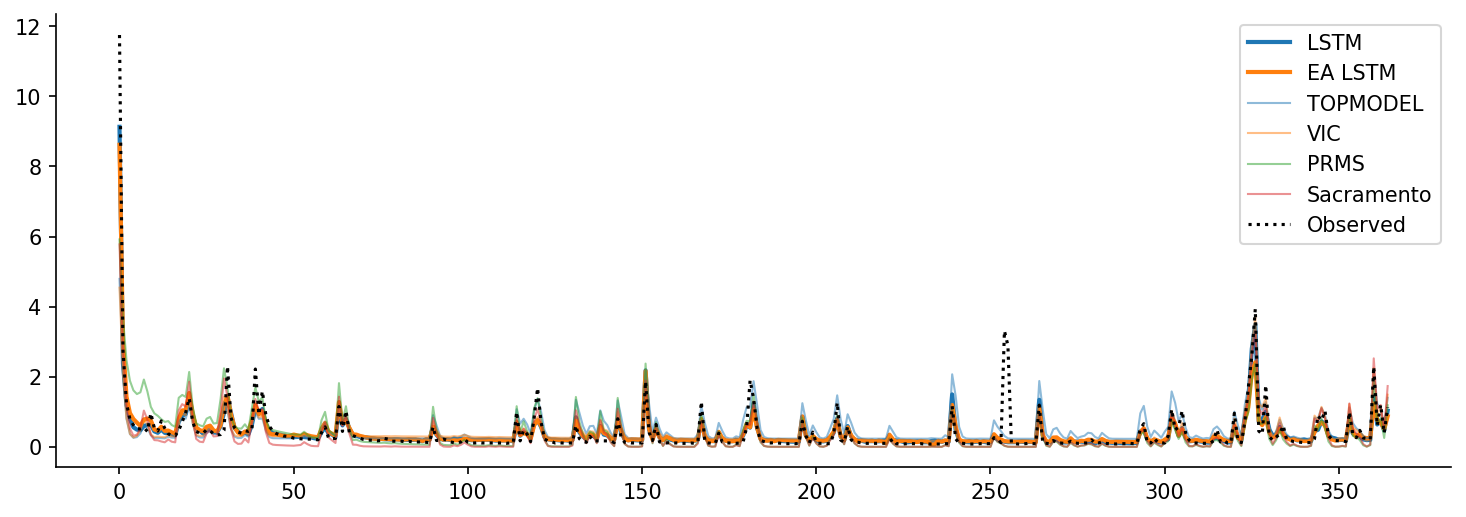

In [216]:
f, ax = plt.subplots(figsize=(12, 4))

data = arid_df.loc["2003"].drop("station_id", axis=1)


ax.plot(np.arange(len(data)), data["LSTM"], color=sns.color_palette()[0], label="LSTM", alpha=1, linewidth=2)
ax.plot(np.arange(len(data)), data["EALSTM"], color=sns.color_palette()[1], label="EA LSTM", alpha=1, linewidth=2)
if plot_conceptual:
    ax.plot(np.arange(len(data)), data["TOPMODEL"], label="TOPMODEL", alpha=0.5, linewidth=1)
    ax.plot(np.arange(len(data)), data["ARNOVIC"], label="VIC", alpha=0.5, linewidth=1)
    ax.plot(np.arange(len(data)), data["PRMS"], label="PRMS", alpha=0.5, linewidth=1)
    ax.plot(np.arange(len(data)), data["SACRAMENTO"], label="Sacramento", alpha=0.5, linewidth=1)

ax.plot(np.arange(len(data)), data["obs"], color="k", ls=":", label="Observed")
ax.legend()

# ax.set_title(f"{}\nNSE: {} -- Bias: {} -- {}")

sns.despine()

# LSTM Errors

In [113]:
PLOT_ALL = False

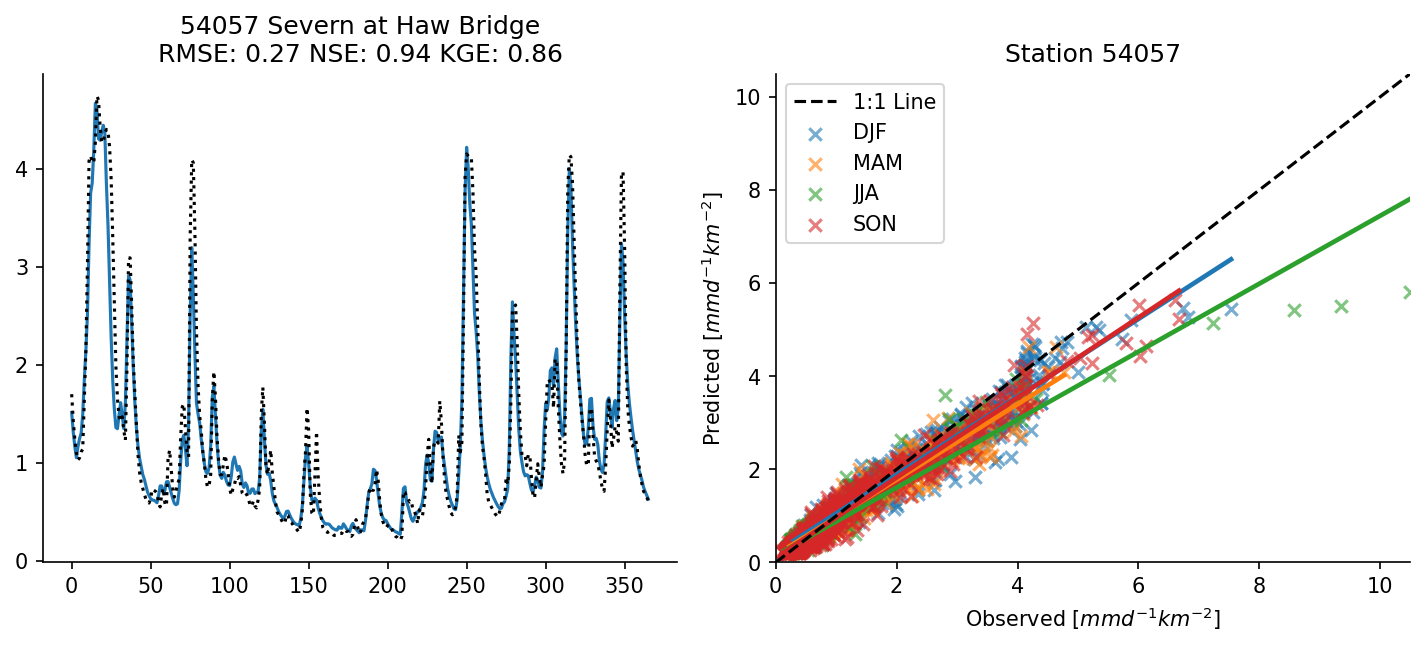

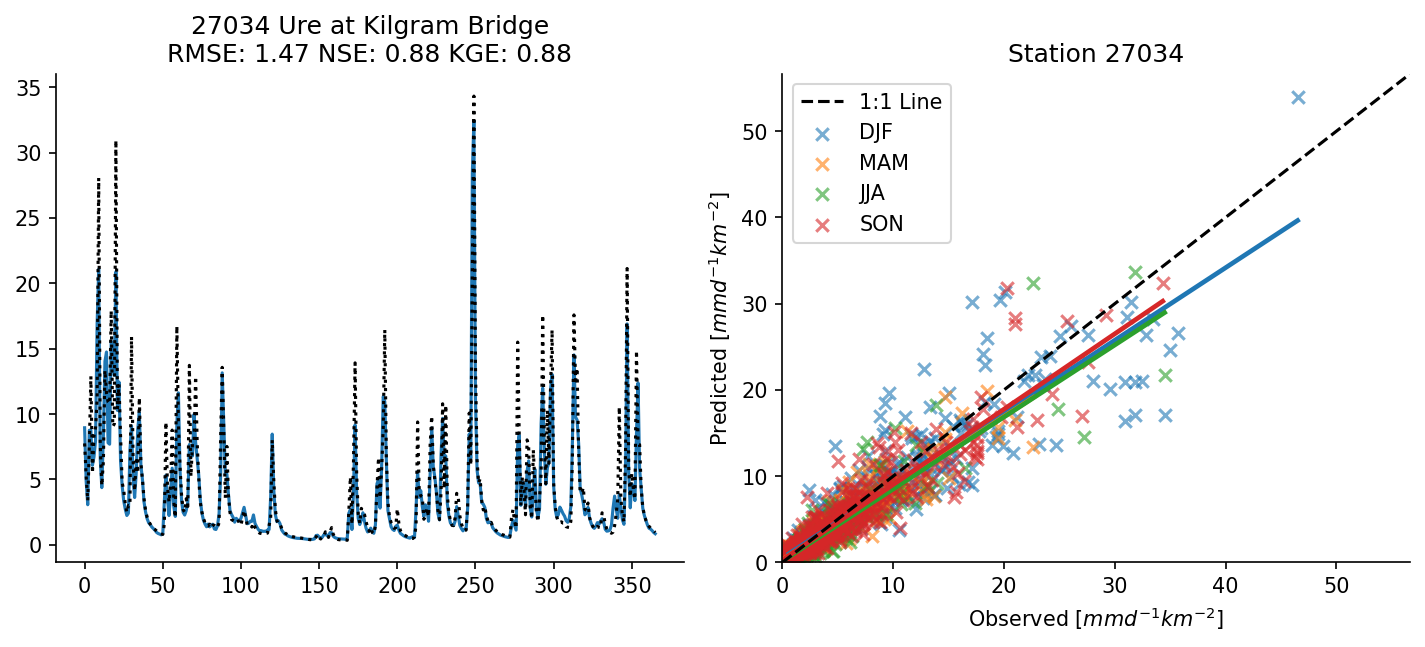

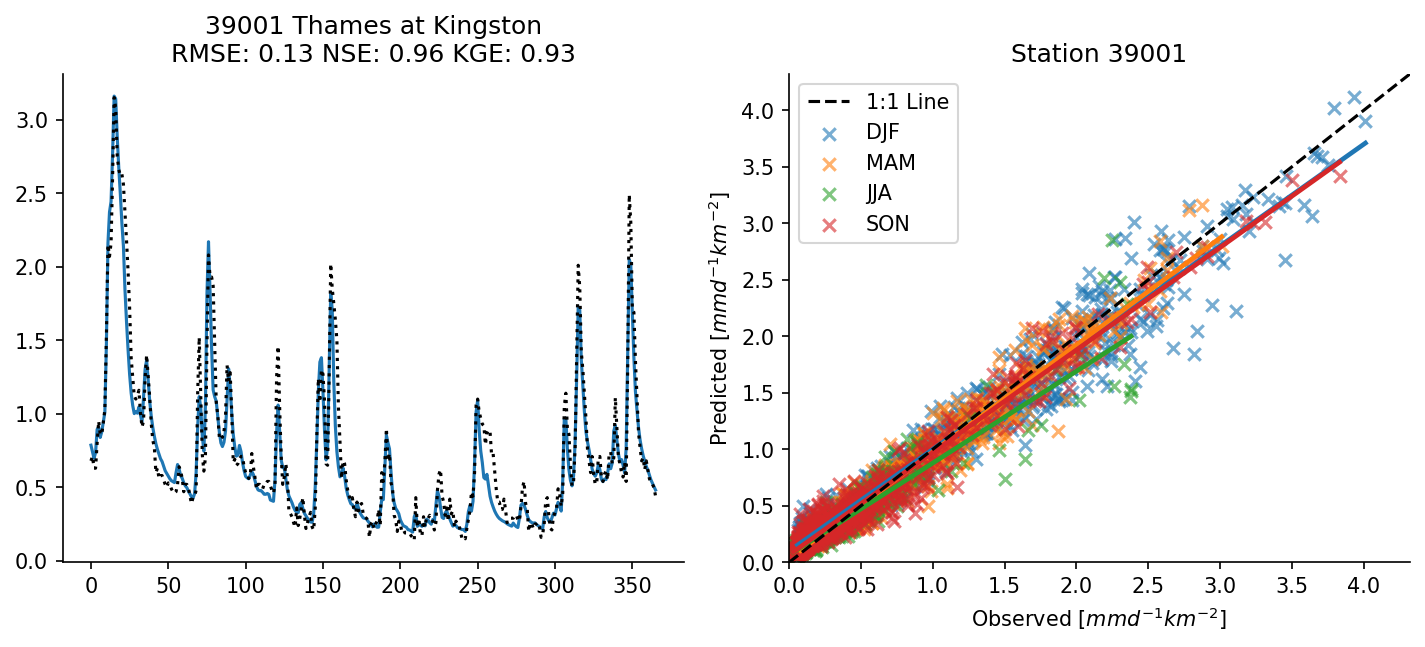

In [114]:
if PLOT_ALL:
    fig, axs = plot_catchment_time_series(
        df=lstm_less_vars.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
        metrics_df=lstm_df,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    sns.despine()
    
else:
    for idx, name in summary_stations:
        fig, axs = plot_catchment_time_series(
            df=lstm_df.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
            metrics_df=lstm_metric_df,
            catchment_ids=[idx],
            catchment_names=[name],
            plot_years=[2008],
            color_by_season=True,
        );
        sns.despine()

,station_id,discharge_spec,preds
time,,,
1998-01-01,1001,2.14,1.830665
1998-01-02,1001,1.81,2.050738
1998-01-03,1001,4.57,2.739982
1998-01-04,1001,3.30,2.700865
1998-01-05,1001,3.10,2.369242
...,...,...,...
2008-12-27,107001,1.39,3.725156
2008-12-28,107001,1.25,3.524839
2008-12-29,107001,1.18,3.286710


# EALSTM Errors

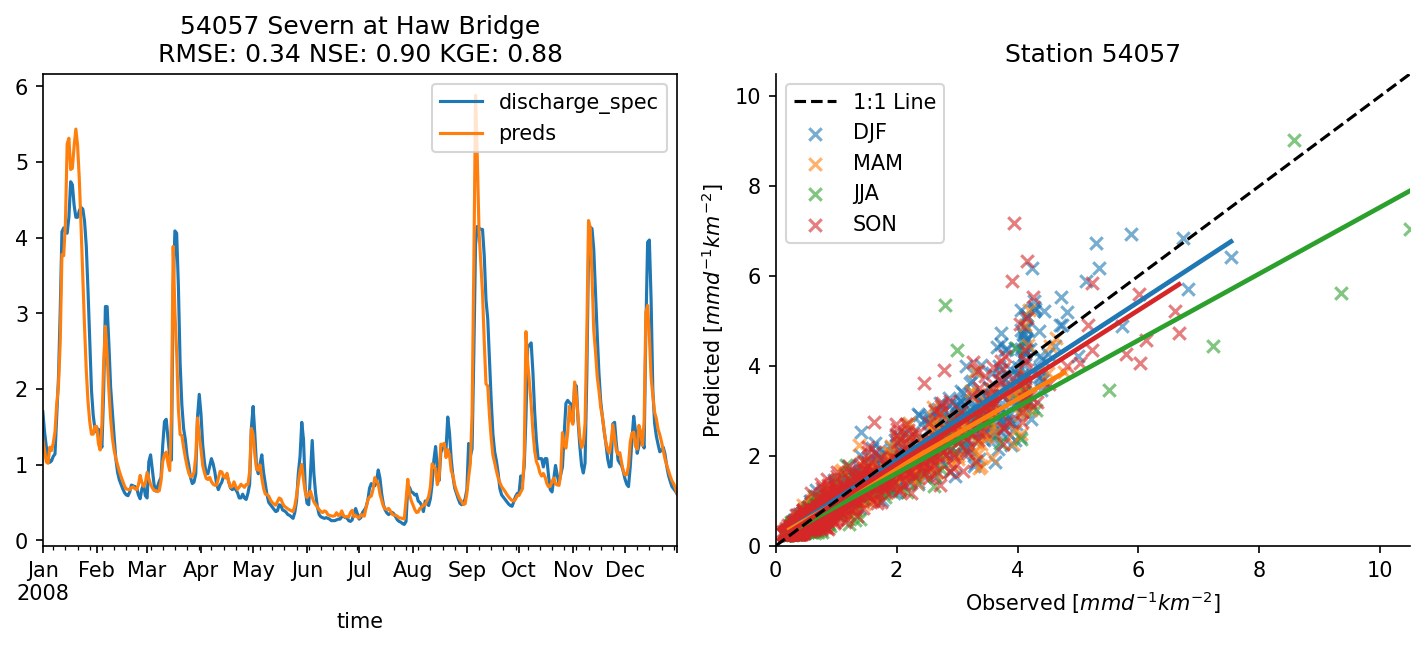

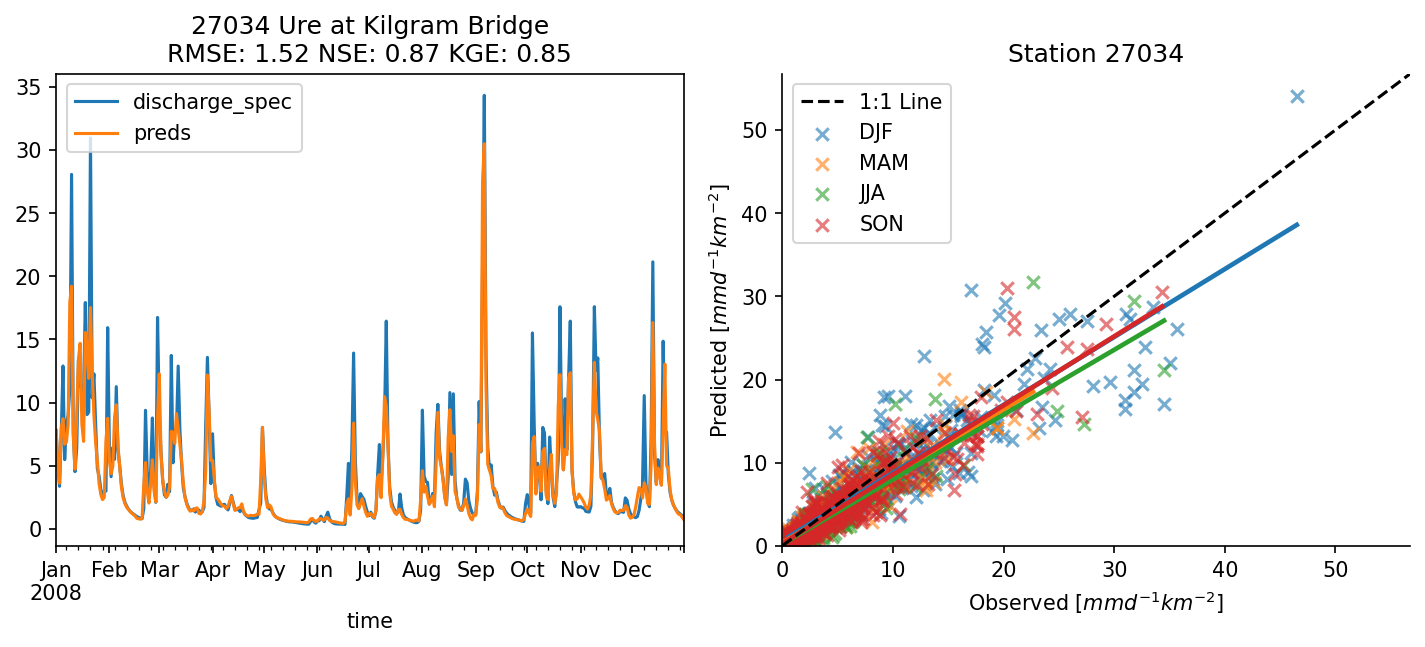

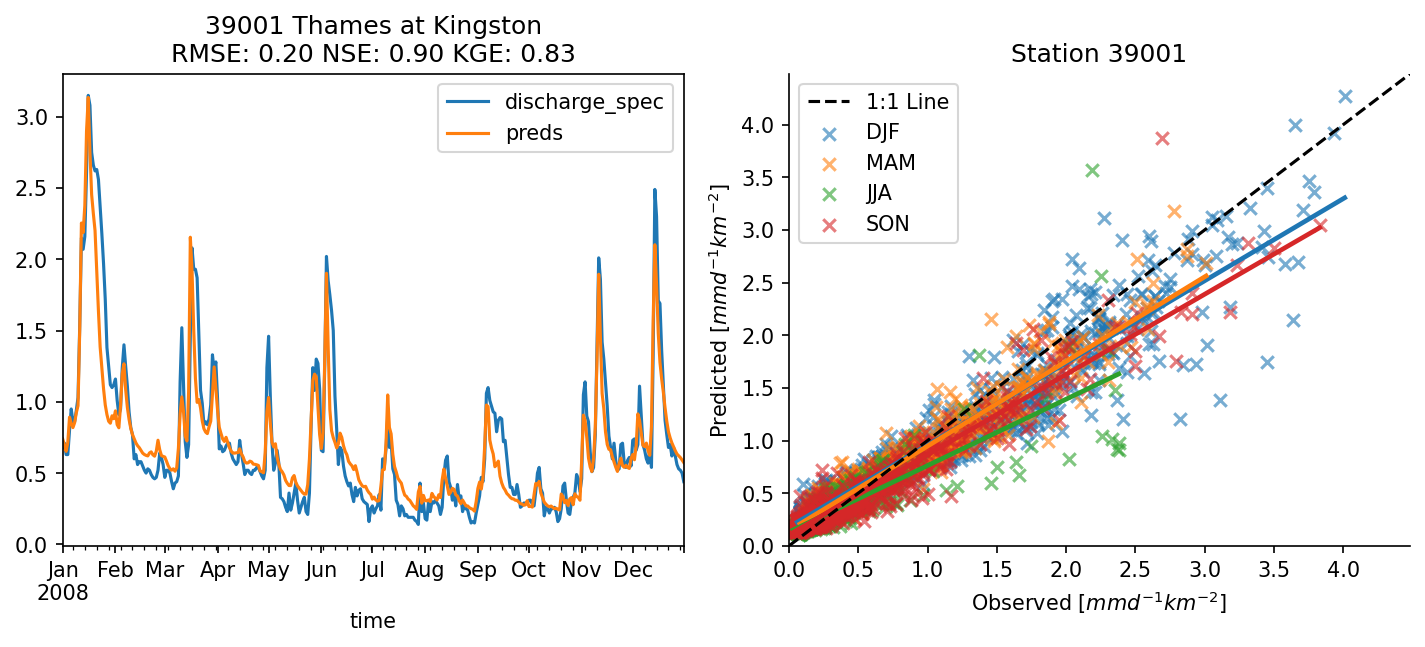

In [62]:
if PLOT_ALL:
    fig, axs = plot_catchment_time_series(
        df=ealstm_df.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
        metrics_df=ealstm_metric_df,
        catchment_ids=catchment_ids,
        catchment_names=catchment_names,
        plot_years=[2008],
        color_by_season=True,
    );
    
else:
    for idx, name in summary_stations:
        fig, axs = plot_catchment_time_series(
            df=ealstm_df.set_index("time").rename({"obs": "discharge_spec", "sim": "preds"}, axis=1),
            metrics_df=ealstm_metric_df,
            catchment_ids=[idx],
            catchment_names=[name],
            plot_years=[2008],
            color_by_season=True,
        );
    

In [83]:
df.head()





obs      LSTM    EALSTM  SimQ_TOPMODEL  SimQ_ARNOVIC  \
station_id time                                                                
33029      2007-01-01  1.05  1.059610  1.085282            NaN           NaN   
           2007-01-02  0.91  0.951619  0.948201            NaN           NaN   
           2007-01-03  0.85  0.853425  0.838254            NaN           NaN   
           2007-01-04  0.77  0.783981  0.764675            NaN           NaN   
           2007-01-05  0.71  0.745473  0.733164            NaN           NaN   

                       SimQ_PRMS  SimQ_SACRAMENTO  
station_id time                                    
33029      2007-01-01        NaN              NaN  
           2007-01-02        NaN              NaN  
           2007-01-03        NaN              NaN  
           2007-01-04        NaN              NaN  
           2007-01-05        NaN              NaN

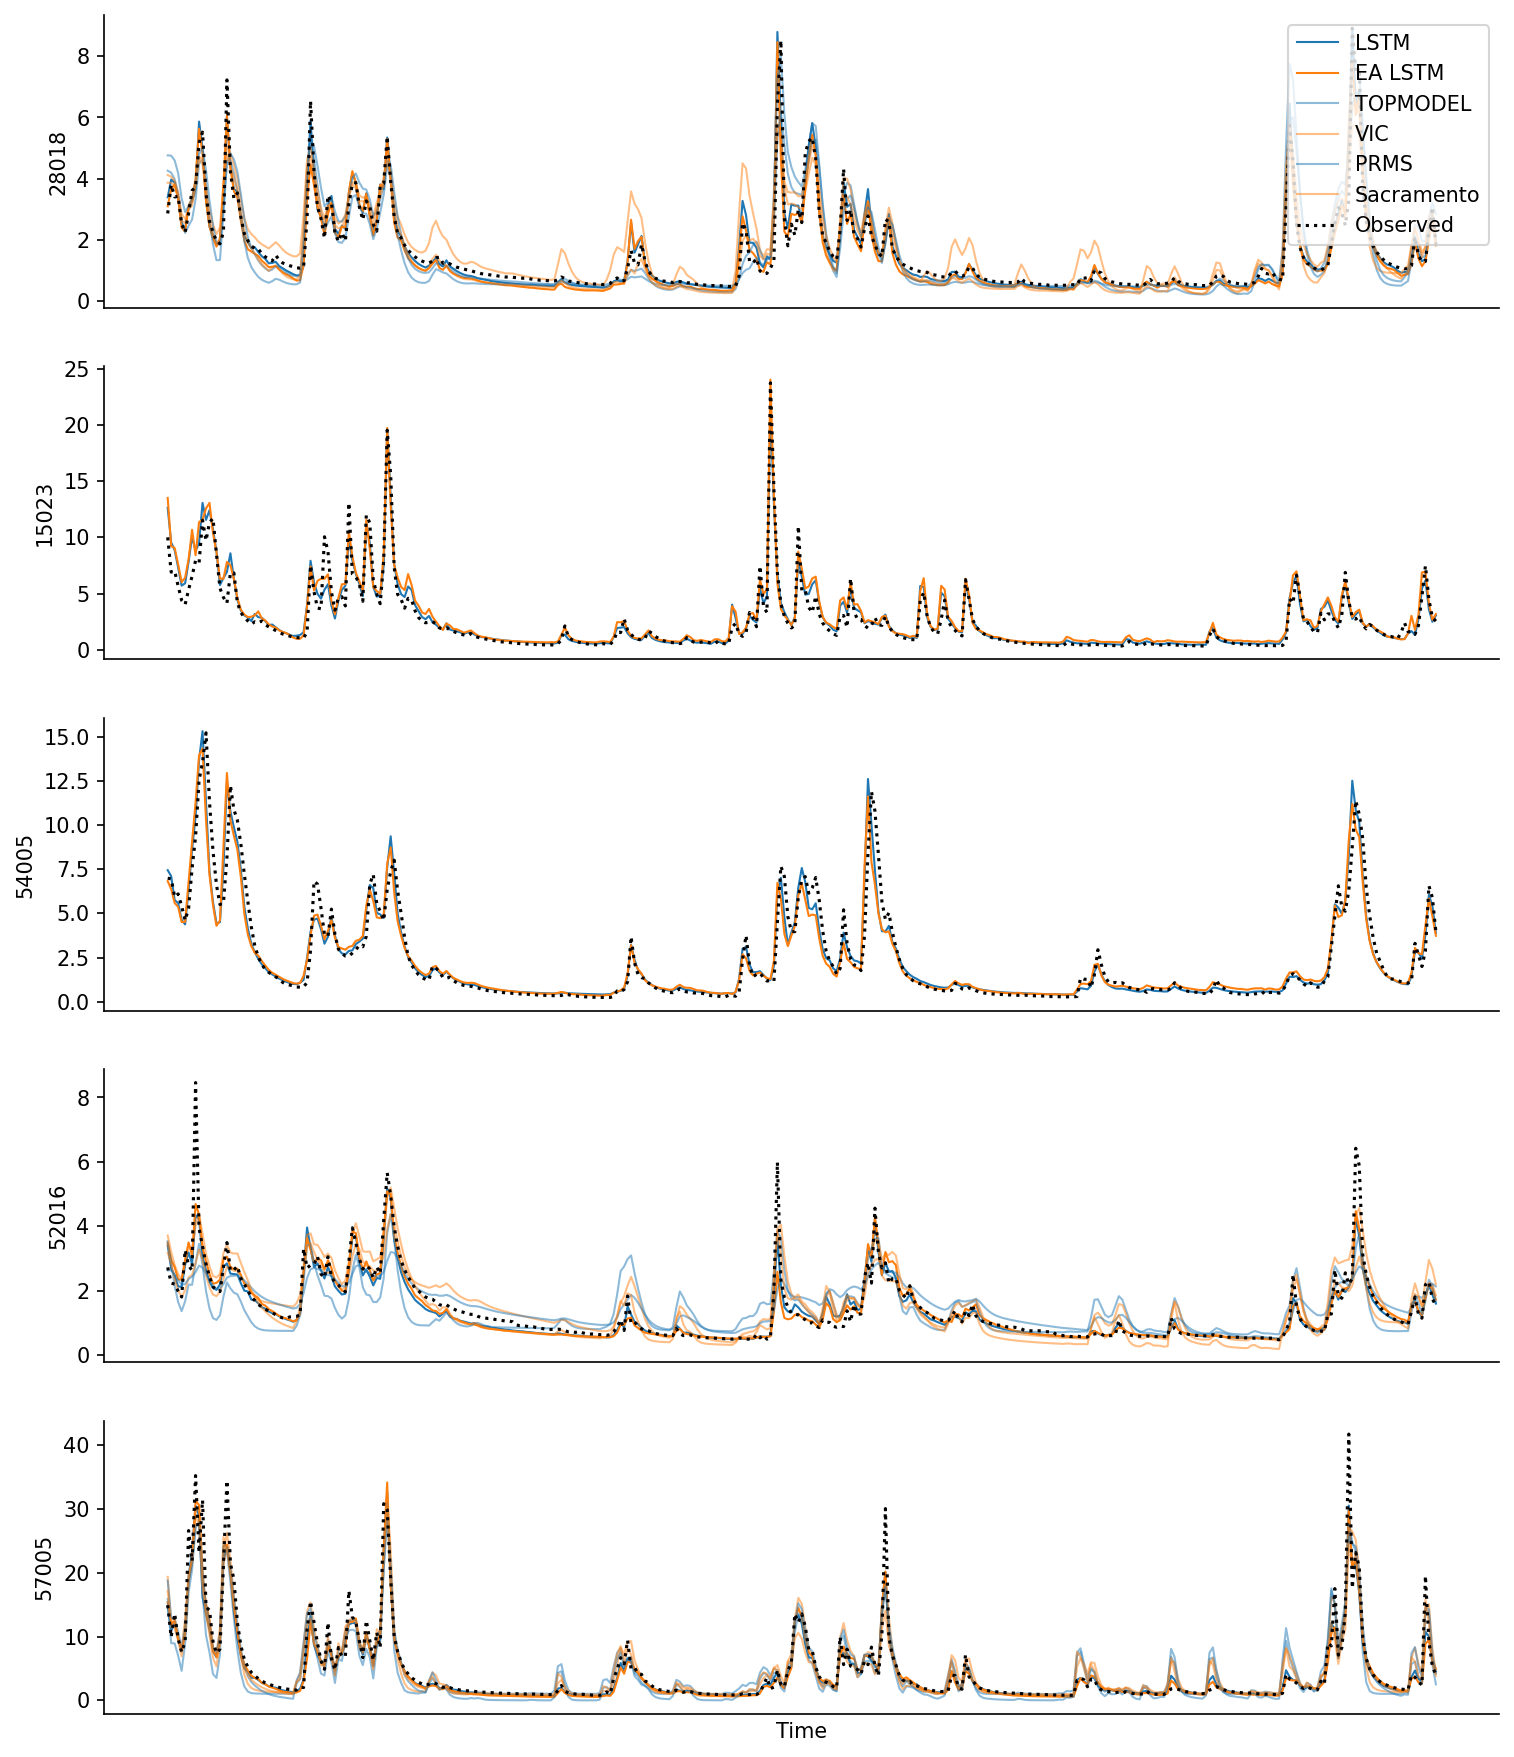

In [93]:
# Plot N random stations
N_STATIONS = 5
plot_conceptual = True

stations = np.random.choice(lstm_preds.station_id.values, N_STATIONS)
df = lstm_preds.sel(station_id=stations, time=(lstm_preds['time.year'] == 2007)).to_dataframe().rename({"sim": "LSTM"}, axis=1)
e_df = (
    ealstm_preds.sel(station_id=stations, time=(ealstm_preds['time.year'] == 2007)).to_dataframe()
    .drop("obs", axis=1).rename({"sim": "EALSTM"}, axis=1)
)
f_df = (
    fuse_ds.sel(station_id=stations[np.isin(stations, fuse_ds.station_id)], time=(fuse_ds['time.year'] == 2007)).to_dataframe()
)
data = (df.join(e_df).join(f_df)).reset_index().set_index("station_id")


f, axs = plt.subplots(N_STATIONS, 1, figsize=(12, 3*N_STATIONS))
for ix, station in enumerate(stations):
    ax = axs[ix]
    df = data.loc[station]
    ax.plot(np.arange(len(df)), df["LSTM"], color=sns.color_palette()[0], label="LSTM", alpha=1, linewidth=1)
    ax.plot(np.arange(len(df)), df["EALSTM"], color=sns.color_palette()[1], label="EA LSTM", alpha=1, linewidth=1)
    if plot_conceptual:
        ax.plot(np.arange(len(df)), df["SimQ_TOPMODEL"], color=sns.color_palette()[0], label="TOPMODEL", alpha=0.5, linewidth=1)
        ax.plot(np.arange(len(df)), df["SimQ_ARNOVIC"], color=sns.color_palette()[1], label="VIC", alpha=0.5, linewidth=1)
        ax.plot(np.arange(len(df)), df["SimQ_PRMS"], color=sns.color_palette()[0], label="PRMS", alpha=0.5, linewidth=1)
        ax.plot(np.arange(len(df)), df["SimQ_SACRAMENTO"], color=sns.color_palette()[1], label="Sacramento", alpha=0.5, linewidth=1)
        
    ax.plot(np.arange(len(df)), df["obs"], color="k", ls=":", label="Observed")
    ax.set_xticks([])
    ax.set_xticklabels([""])
    ax.set_ylabel(f"{station}")
    if ix == 0:
        ax.legend()
    if ix == N_STATIONS - 1:
        ax.set_xlabel("Time")
sns.despine()

# Comparison of ML Model Predictions

In [ ]:
stations

In [ ]:
def join_ml_preds(station: int, year: int = 2007):
    # lstm ensemble
    d1 = lstm_ensemble.sel(station_id=station, time=(lstm_ensemble['time.year'] == year)).to_dataframe().reset_index().set_index(["time", "station_id"]).rename({"sim": "ensemble_lstm"}, axis=1)
    # lstm 
    d2 = lstm_preds.sel(station_id=station, time=(lstm_preds['time.year'] == year)).to_dataframe().drop("obs", axis=1).reset_index().set_index(["time", "station_id"]).rename({"sim": "lstm"}, axis=1)
    # ealstm
    d3 = ealstm_preds.sel(station_id=station, time=(ealstm_preds['time.year'] == year)).to_dataframe().drop("obs", axis=1).reset_index().set_index(["time", "station_id"]).rename({"sim": "ealstm"}, axis=1)

    df = d1.join(d2).join(d3)
    return df

In [ ]:
stations = np.random.choice(lstm_ensemble.station_id.values, 10)

f, axs = plt.subplots(10, 1, figsize=(12, 2*10))
for ix, station in enumerate(stations):
    ax = axs[ix]
    # df = lstm_ensemble.sel(station_id=station, time=(lstm_ensemble['time.year'] == 2007)).to_dataframe()
    df = join_ml_preds(station, year=2007)
    ax.plot(np.arange(len(df)), df["obs"], color="k", ls=":", label="Observed")
    ax.plot(np.arange(len(df)), df["lstm"], color=sns.color_palette()[0], label="LSTM")
    ax.plot(np.arange(len(df)), df["ealstm"], color=sns.color_palette()[1], label="EALSTM")
    ax.plot(np.arange(len(df)), df["ensemble_lstm"], color=sns.color_palette()[2], label="Ensemble LSTM")
    ax.set_xticks([])
    ax.set_xticklabels([""])
    ax.set_ylabel(f"{station}")
    if ix == 0:
        ax.legend()
    if ix == 9:
        ax.set_xlabel("Time")
sns.despine()

# PRMS

# TOPMODEL

# VIC

# SACRAMENTO